In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2025-06-04 11:18:21--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   117MB/s    in 0.7s    

2025-06-04 11:18:22 (117 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=p

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

**Calculate Lipinski descriptors**


Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

Molecular weight < 500 Dalton
Octanol-water partition coefficient (LogP) < 5
Hydrogen bond donors < 5
Hydrogen bond acceptors < 10

**Import libraries**

In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 29.2 MB 2.2 MB/s 


In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

**Calculate descriptors**

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [ ]:
df_lipinski = lipinski(df.canonical_smiles)

**Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [ ]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,218.208,1.4696,1.0,3.0
1,215.134,1.3369,1.0,3.0
2,331.759,2.8194,1.0,5.0
3,299.305,2.2165,1.0,4.0


In [ ]:
df

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL278488,CC1(c2ccccc2)OC(C(=O)O)=CC1=O,3000.0
1,CHEMBL1223819,O=c1[nH]c(C(F)(F)F)nc2ncccc12,50000.0
2,CHEMBL1224070,O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12,33000.0
3,CHEMBL1224147,O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12,50000.0


Now, let's combine the 2 DataFrame

In [ ]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL278488,CC1(c2ccccc2)OC(C(=O)O)=CC1=O,3000.0,218.208,1.4696,1.0,3.0
1,CHEMBL1223819,O=c1[nH]c(C(F)(F)F)nc2ncccc12,50000.0,215.134,1.3369,1.0,3.0
2,CHEMBL1224070,O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12,33000.0,331.759,2.8194,1.0,5.0
3,CHEMBL1224147,O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12,50000.0,299.305,2.2165,1.0,4.0


**Convert IC50 to pIC50**

To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10 −9
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)

    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [ ]:
df_combined.standard_value.describe()

,standard_value
count,4.000000
mean,34000.000000
std,22166.040091
min,3000.000000
25%,25500.000000
50%,41500.000000
75%,50000.000000
max,50000.000000


In [ ]:
-np.log10( (10**-9)* 100000000 )

np.float64(1.0)

In [ ]:
-np.log10( (10**-9)* 10000000000 )

np.float64(-1.0)

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [ ]:
def norm_value(input):
    norm = []
    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1) # Correcte
    return x


In [ ]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL278488,CC1(c2ccccc2)OC(C(=O)O)=CC1=O,218.208,1.4696,1.0,3.0,3000.0
1,CHEMBL1223819,O=c1[nH]c(C(F)(F)F)nc2ncccc12,215.134,1.3369,1.0,3.0,50000.0
2,CHEMBL1224070,O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12,331.759,2.8194,1.0,5.0,33000.0
3,CHEMBL1224147,O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12,299.305,2.2165,1.0,4.0,50000.0


In [ ]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,4.000000
mean,34000.000000
std,22166.040091
min,3000.000000
25%,25500.000000
50%,41500.000000
75%,50000.000000
max,50000.000000


In [ ]:


def pIC50(input):
    pic50_values = []
    if 'standard_value_norm' not in input.columns:

        print("Error: 'standard_value_norm' column is missing in the DataFrame passed to pIC50.")
        print("Make sure the norm_value function ran correctly and created this column.")
        return input
    for i in input['standard_value_norm']:
        molar = i * (10**-9)
        if molar <= 0: # Avoid log(0) or log(negative)
            pic50_values.append(np.nan) # Or handle as appropriate
        else:
            pic50_values.append(-np.log10(molar))

    input['pIC50'] = pic50_values
    x = input.drop('standard_value_norm', axis=1) # Corrected
    return x

In [ ]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL278488,CC1(c2ccccc2)OC(C(=O)O)=CC1=O,218.208,1.4696,1.0,3.0,5.522879
1,CHEMBL1223819,O=c1[nH]c(C(F)(F)F)nc2ncccc12,215.134,1.3369,1.0,3.0,4.301030
2,CHEMBL1224070,O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12,331.759,2.8194,1.0,5.0,4.481486
3,CHEMBL1224147,O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12,299.305,2.2165,1.0,4.0,4.301030


In [ ]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,4.000000
mean,34000.000000
std,22166.040091
min,3000.000000
25%,25500.000000
50%,41500.000000
75%,50000.000000
max,50000.000000


In [ ]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL278488,CC1(c2ccccc2)OC(C(=O)O)=CC1=O,218.208,1.4696,1.0,3.0,5.522879
1,CHEMBL1223819,O=c1[nH]c(C(F)(F)F)nc2ncccc12,215.134,1.3369,1.0,3.0,4.301030
2,CHEMBL1224070,O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12,331.759,2.8194,1.0,5.0,4.481486
3,CHEMBL1224147,O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12,299.305,2.2165,1.0,4.0,4.301030


In [ ]:
df_final.pIC50.describe()

,pIC50
count,4.000000
mean,4.651606
std,0.587045
min,4.301030
25%,4.301030
50%,4.391258
75%,4.741834
max,5.522879


**Removing the 'intermediate' bioactivity class**

Here, we will be removing the intermediate class from our data set.



In [ ]:
print(df_final.columns)
print(df_final.head())

Index(['molecule_chembl_id', 'canonical_smiles', 'MW', 'LogP', 'NumHDonors',
       'NumHAcceptors', 'pIC50'],
      dtype='object')
  molecule_chembl_id                      canonical_smiles       MW    LogP  \
0       CHEMBL278488         CC1(c2ccccc2)OC(C(=O)O)=CC1=O  218.208  1.4696   
1      CHEMBL1223819         O=c1[nH]c(C(F)(F)F)nc2ncccc12  215.134  1.3369   
2      CHEMBL1224070  O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12  331.759  2.8194   
3      CHEMBL1224147  O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12  299.305  2.2165   

   NumHDonors  NumHAcceptors     pIC50  
0         1.0            3.0  5.522879  
1         1.0            3.0  4.301030  
2         1.0            5.0  4.481486  
3         1.0            4.0  4.301030  


In [ ]:
# Example: Define bioactivity_class based on pIC50
# Adjust these thresholds as per your project's definitions

bioactivity_threshold = []
for i in df_final['pIC50']: # Make sure pIC50 exists and is correctly calculated
    if float(i) >= 6.0: # Example: pIC50 >= 6 is 'active'
        bioactivity_threshold.append("active")
    elif float(i) <= 5.0: # Example: pIC50 <= 5 is 'inactive'
        bioactivity_threshold.append("inactive")
    else: # Example: pIC50 between 5 and 6 is 'intermediate'
        bioactivity_threshold.append("intermediate")

# Add the new column to df_final
df_final['bioactivity_class'] = bioactivity_threshold

# Now you can verify it exists
print(df_final.head())

  molecule_chembl_id                      canonical_smiles       MW    LogP  \
0       CHEMBL278488         CC1(c2ccccc2)OC(C(=O)O)=CC1=O  218.208  1.4696   
1      CHEMBL1223819         O=c1[nH]c(C(F)(F)F)nc2ncccc12  215.134  1.3369   
2      CHEMBL1224070  O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12  331.759  2.8194   
3      CHEMBL1224147  O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12  299.305  2.2165   

   NumHDonors  NumHAcceptors     pIC50 bioactivity_class  
0         1.0            3.0  5.522879      intermediate  
1         1.0            3.0  4.301030          inactive  
2         1.0            5.0  4.481486          inactive  
3         1.0            4.0  4.301030          inactive  


In [ ]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
print(df_2class.head())
print(df_2class['bioactivity_class'].value_counts()) # To verify 'intermediate' is gone

  molecule_chembl_id                      canonical_smiles       MW    LogP  \
1      CHEMBL1223819         O=c1[nH]c(C(F)(F)F)nc2ncccc12  215.134  1.3369   
2      CHEMBL1224070  O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12  331.759  2.8194   
3      CHEMBL1224147  O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12  299.305  2.2165   

   NumHDonors  NumHAcceptors     pIC50 bioactivity_class  
1         1.0            3.0  4.301030          inactive  
2         1.0            5.0  4.481486          inactive  
3         1.0            4.0  4.301030          inactive  
bioactivity_class
inactive    3
Name: count, dtype: int64


In [ ]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,bioactivity_class
1,CHEMBL1223819,O=c1[nH]c(C(F)(F)F)nc2ncccc12,215.134,1.3369,1.0,3.0,4.301030,inactive
2,CHEMBL1224070,O=c1[nH]c(OCCCOc2ccccc2Cl)nc2ncccc12,331.759,2.8194,1.0,5.0,4.481486,inactive
3,CHEMBL1224147,O=c1[nH]c(COCCc2ccc(F)cc2)nc2ncccc12,299.305,2.2165,1.0,4.0,4.301030,inactive


**Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

**Import library**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt


**Frequency plot of the 2 bioactivity classes**

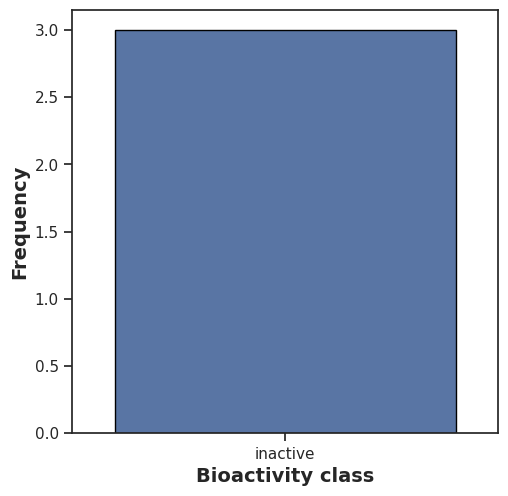

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

**Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

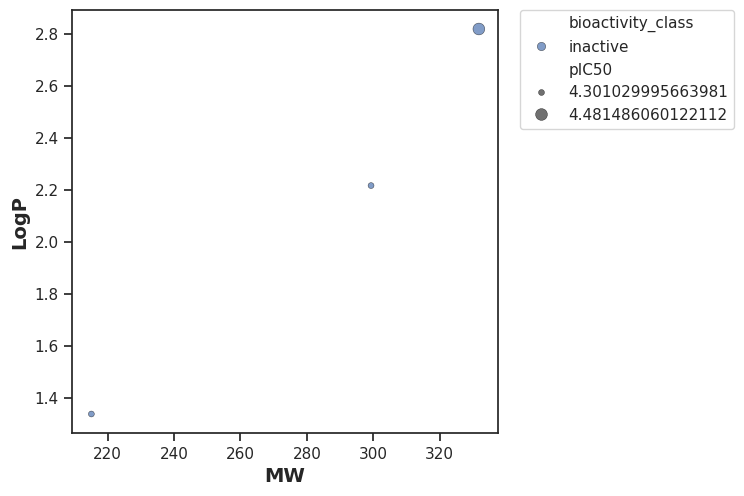

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

**pIC50 value**

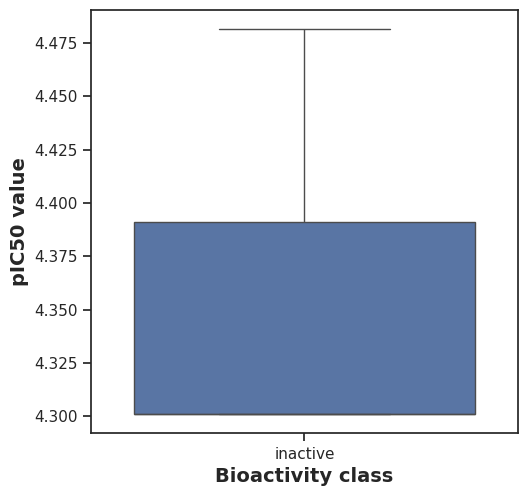

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

<ipython-input-64-8a412ca85d5a>:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(active, inactive)


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,NaN,NaN,0.05,Different distribution (reject H0)


**MW**

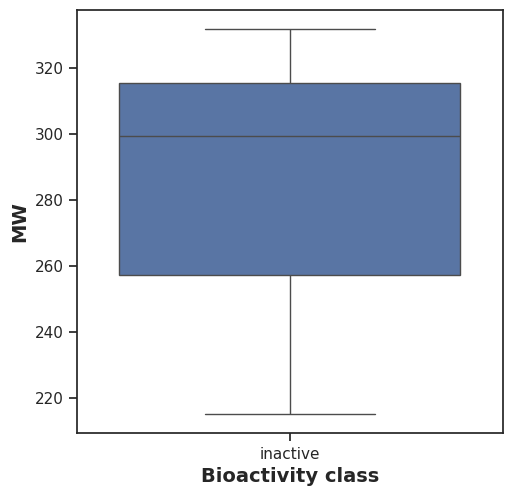

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

<ipython-input-64-8a412ca85d5a>:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(active, inactive)


,Descriptor,Statistics,p,alpha,Interpretation
0,MW,NaN,NaN,0.05,Different distribution (reject H0)


**LogP**

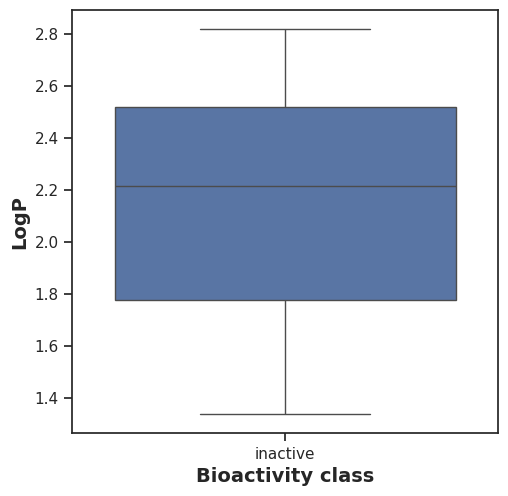

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

<ipython-input-64-8a412ca85d5a>:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(active, inactive)


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,NaN,NaN,0.05,Different distribution (reject H0)


**NumHDonor**s

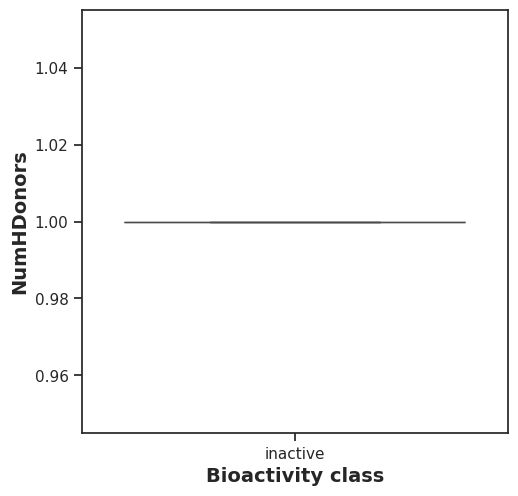

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

<ipython-input-64-8a412ca85d5a>:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(active, inactive)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,NaN,NaN,0.05,Different distribution (reject H0)


**NumHAcceptors**

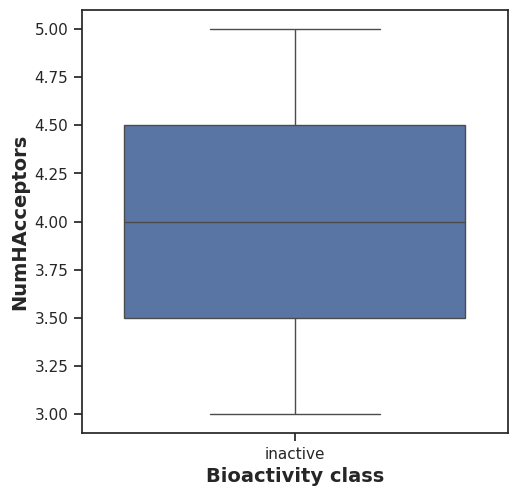

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

<ipython-input-64-8a412ca85d5a>:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(active, inactive)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,NaN,NaN,0.05,Different distribution (reject H0)


**Interpretation of Statistical Results**

**Box Plots**
**pIC50 values **

Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

Lipinski's descriptors
Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited no difference between the actives and inactives while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows statistically significant difference between actives and inactives.

**Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_NumHDonors.csv (deflated 9%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
  adding: plot_NumHDonors.pdf (deflated 37%)
  adding: plot_MW_vs_LogP.pdf (deflated 34%)
  adding: mannwhitneyu_LogP.csv (deflated 6%)
  adding: mannwhitneyu_pIC50.csv (deflated 9%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: mannwhitneyu_MW.csv (deflated 6%)
  adding: bioactivity_preprocessed_data.csv (deflated 39%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: plot_MW.pdf (deflated 38%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 38%)
